In [49]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import tqdm
import re
import itertools

import datatable as dt
import seaborn as sns
import umap.umap_ as umap

from sklearn.cluster import AgglomerativeClustering

Clustering without a model

In [76]:
path = r"C:\Users\Acer\Git\deda_punks\Crypto_punks\for sale"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
punks = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # add the image files to the list
            punks.append(file.name)

In [77]:
punks_img = []
for image in tqdm.tqdm(punks):
    punks_img.append(plt.imread(image).flatten())
    
punks_img = np.stack(punks_img)

100%|████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:00<00:00, 1657.75it/s]


In [48]:
brain_umap = umap.UMAP(random_state=999)

# Fit UMAP and extract latent vars 1-2
embedding = pd.DataFrame(brain_umap.fit_transform(punks_img), columns = ['UMAP1','UMAP2'])

In [78]:
clustered = AgglomerativeClustering(linkage = "average", n_clusters=200)
clustered.fit(punks_img)

AgglomerativeClustering(linkage='average', n_clusters=200)

In [69]:
clustered = AgglomerativeClustering(linkage = "average", distance_threshold=10, n_clusters=None)
clustered.fit(punks_img)

AgglomerativeClustering(distance_threshold=10, linkage='average',
                        n_clusters=None)

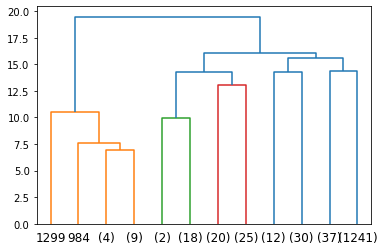

In [70]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plot_dendrogram(clustered, truncate_mode='level', p=3)

In [79]:
# holds the cluster id and the images { id: [images] }

def post_process_clustering (model):
    groups = {}
    for file, cluster in zip(punks,model.labels_):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [80]:
#filenames = np.array(list(data.keys()))
groups = post_process_clustering(clustered)

In [81]:
#pic_cluster_id = []
from PIL import Image
for i in [0, 63, 82]: # or len(groups) to display all clusters
    print("Cluster number", i)
    for mini_punk in groups[i]:
        img = Image.open(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\for sale\\"+mini_punk)  
        display (img)
        #print(mini_punk)
        #pic_cluster_id.append([display(img), i])


Cluster number 0


Cluster number 63


Cluster number 82


Clustering with the model

In [2]:
path = r"C:\Users\Acer\Git\deda_punks\Crypto_punks\for sale"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
punks = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            punks.append(file.name)

In [3]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [4]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [5]:
# load model
model2 = VGG16()
# remove the output layer
model2 = Model(inputs=model2.inputs, outputs=model2.layers[1].output)

img = np.array(img) 
# reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
reshaped_img = img.reshape(1,224,224,3) 
# prepare image for model
imgx = preprocess_input(reshaped_img)
# get the feature vector
features_1 = model2.predict(imgx)

NameError: name 'img' is not defined

In [ ]:
square = 8
ix = 1

for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features_1[0,:,:,ix-1])
        ix +=1
plt.savefig("vgg16_last_layer.png")    

In [ ]:
# load model
model2 = VGG16()
# remove the output layer
model2 = Model(inputs=model2.inputs, outputs=model2.layers[17].output)

img = np.array(img) 
# reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
reshaped_img = img.reshape(1,224,224,3) 
# prepare image for model
imgx = preprocess_input(reshaped_img)
# get the feature vector
features_1 = model2.predict(imgx)

In [7]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [11]:
data = {}
p = r"C:\Users\Acer\Git\deda_punks\punks_features_.pkl"

# lop through each image in the dataset
for punk in tqdm.tqdm(punks):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(punk,model)
        data[punk] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [13:32<00:00,  1.72it/s]


In [ ]:
img = load_img(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\bids\Punk 0310.png", target_size=(224,224))

In [ ]:
img2 = np.array(img)

In [ ]:
plt.imshow(img2, interpolation=None)

In [ ]:
plt.imsave(r'C:\Users\Acer\Git\deda_punks\Punk 0310.png', img2)

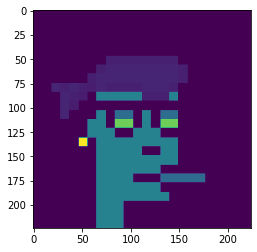

In [132]:
from matplotlib import pyplot as plt
plt.imshow(img2[:,:,0], interpolation=None)
#plt.show()
plt.imsave(r'C:\Users\Acer\Git\deda_punks\R__.png', img2[:,:,0])
#red

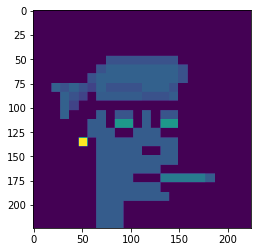

In [130]:
from matplotlib import pyplot as plt
plt.imshow(img2[:,:,1], interpolation=None)
#plt.show()
plt.imsave(r'C:\Users\Acer\Git\deda_punks\G__.png', img2[:,:,1])
#green

In [9]:
from matplotlib import pyplot as plt
plt.imshow(img2[:,:,2], interpolation=None)
#plt.show()
plt.imsave(r'C:\Users\Acer\Git\deda_punks\B__.png', img2[:,:,2])
#blue

NameError: name 'img2' is not defined

In [12]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
print(feat.shape)

(1400, 1, 4096)
(1400, 4096)


In [13]:
pca = PCA(n_components=150, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [6]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig(r"C:\Users\Acer\Git\deda_punks\PCA.png")
# 150 components explain almost 95% of the variance

NameError: name 'pca' is not defined

In [73]:
feat.shape

(908, 4096)

In [236]:
from sklearn.cluster import DBSCAN

In [14]:
from sklearn.cluster import AgglomerativeClustering

In [20]:
from sklearn.cluster import SpectralClustering

In [286]:
clustered = DBSCAN(eps=20, min_samples=4).fit(x)

In [31]:
clustered = AgglomerativeClustering(n_clusters=200, linkage = "average")
clustered.fit(x)

AgglomerativeClustering(linkage='average', n_clusters=200)

In [21]:
clustered = SpectralClustering(n_clusters=30)
clustered.fit(x)

c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [28]:
clustered = KMeans(n_clusters=200, n_jobs=-1)
clustered.fit(x)

c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=200, n_jobs=-1)

In [16]:
# holds the cluster id and the images { id: [images] }

def post_process_clustering (model):
    groups = {}
    for file, cluster in zip(filenames,model.labels_):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [32]:
groups = post_process_clustering(clustered)

In [291]:
from PIL import Image

for i in range(len(groups)):
    #print("Group", i)
    for mini_punk in groups[i]:
        img = Image.open(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\bids\\"+mini_punk)
        #display(img)
        if mini_punk == "Punk 0310.png":
            display(img)
            print("Group", i)
            new_group = i

KeyError: 0

In [292]:
from PIL import Image

for i in range(len(groups)):
    #print("Group", i)
    for mini_punk in groups[i-1]:
        img = Image.open(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\bids\\"+mini_punk)
        #display(img)
        if mini_punk == "Punk 0310.png":
            display(img)
            print("Group", i-1)
            new_group = i-1

KeyError: -1

In [284]:
groups[new_group]

['Punk 0052.png',
 'Punk 0112.png',
 'Punk 0207.png',
 'Punk 0310.png',
 'Punk 0432.png',
 'Punk 0441.png',
 'Punk 0527.png',
 'Punk 0622.png',
 'Punk 0636.png',
 'Punk 0649.png',
 'Punk 0686.png',
 'Punk 0690.png',
 'Punk 0728.png',
 'Punk 0798.png',
 'Punk 0934.png',
 'Punk 1091.png',
 'Punk 1100.png',
 'Punk 1119.png',
 'Punk 1155.png',
 'Punk 1197.png',
 'Punk 1203.png',
 'Punk 1213.png',
 'Punk 1228.png',
 'Punk 1252.png',
 'Punk 1283.png',
 'Punk 1293.png',
 'Punk 1371.png',
 'Punk 1418.png',
 'Punk 1462.png',
 'Punk 1474.png',
 'Punk 1492.png',
 'Punk 1648.png',
 'Punk 1729.png',
 'Punk 1819.png',
 'Punk 1822.png',
 'Punk 1898.png',
 'Punk 1922.png',
 'Punk 1984.png',
 'Punk 2134.png',
 'Punk 2169.png',
 'Punk 2219.png',
 'Punk 2267.png',
 'Punk 2279.png',
 'Punk 2321.png',
 'Punk 2355.png',
 'Punk 2424.png',
 'Punk 2436.png',
 'Punk 2551.png',
 'Punk 2726.png',
 'Punk 2747.png',
 'Punk 2766.png',
 'Punk 2849.png',
 'Punk 2859.png',
 'Punk 3084.png',
 'Punk 3113.png',
 'Punk 315

In [285]:
for mini_punk in groups[new_group]:
    img = Image.open(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\bids\\"+mini_punk)
    display (img)

In [50]:
groups[0][0]

'Punk 2071.png'

In [62]:
df = pd.DataFrame(x).join(pd.DataFrame(clustered.labels_, columns = ["label"]))

In [64]:
import random

[30, 102, 184, 11, 23, 43, 85, 51, 8, 162]

In [68]:
df_sample = df[df.label.isin(random.sample(range(0, 200), 5))].copy()

In [72]:
df_sample[df_sample.label == i][1]

372      6.059032
416      1.927467
510     12.774735
660      1.142852
776      5.180991
862     11.113215
870      3.272101
883      6.856484
895      2.398916
928      1.334946
967      4.327823
978      3.040176
997      7.688049
1166    11.156052
1179     9.174016
1220     4.742665
1257     5.880375
1276     4.478175
1285    -2.060172
1324     6.487510
1364     2.281044
Name: 1, dtype: float32

In [70]:
#Getting unique labels
 
u_labels = np.unique(df_sample.label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df_sample[df_sample.label == i , 0] , df_sample[df_sample.label == i , 1] , label = i)
plt.legend()
plt.show()

TypeError: '(2       False
19      False
63      False
138     False
168     False
259     False
299     False
310     False
372      True
376     False
405     False
412     False
416      True
510      True
516     False
609     False
614     False
660      True
693     False
711     False
731     False
752     False
776      True
862      True
870      True
883      True
895      True
928      True
930     False
967      True
978      True
997      True
1031    False
1089    False
1142    False
1166     True
1179     True
1220     True
1257     True
1276     True
1285     True
1324     True
1364     True
1366    False
Name: label, dtype: bool, 0)' is an invalid key

In [73]:
df

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,label
0,12.783647,7.297367,-1.455670,-5.876994,-0.867450,5.136021,1.551253,-5.104311,-0.403887,1.156508,...,0.046208,-0.243786,0.145448,0.439010,0.147346,-0.580648,-0.012276,-0.271233,0.077991,70
1,-8.867982,-10.118273,-2.162279,-5.511005,-8.238152,-2.623692,2.417528,5.815327,5.126099,1.350657,...,0.059721,-0.506675,0.249950,0.016045,-0.147489,0.563227,0.487285,-0.296139,0.118540,38
2,4.827444,-3.703674,13.400764,-3.014267,8.445823,0.002135,-4.578975,-3.738563,1.351906,-4.559989,...,0.138676,-0.561083,0.113047,-0.111528,0.002370,-0.357439,-0.531122,0.094053,-0.117350,44
3,-2.046654,2.312950,-13.206139,-5.870577,1.296663,3.459150,-2.472404,-6.532020,-0.561662,-4.120446,...,0.388495,-0.369866,-0.233983,-0.079728,-0.484586,0.198315,0.665404,-0.162822,0.220766,73
4,-1.920380,5.989769,-10.692387,-2.381644,1.643752,-2.115313,-1.617631,0.610548,1.223313,-1.049790,...,-0.539666,-0.019241,0.073964,-0.429236,0.261481,0.585525,-0.005201,-0.194252,-0.148360,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,-6.333237,-2.859255,2.324775,-8.762263,-1.745828,1.380051,-5.545579,8.381204,0.891173,3.269184,...,0.571815,-0.606922,0.171673,0.585010,1.425341,-0.314852,-0.514204,0.166305,-0.563683,77
1396,-13.212597,2.161695,8.735480,9.167615,-6.266041,-1.082254,12.058297,-3.229502,1.574637,-4.697832,...,-0.499724,-0.004003,-0.225388,0.200352,-0.059195,0.079255,-0.566379,0.089432,-0.189370,65
1397,-2.151030,3.443088,-0.433633,-9.628588,-5.187509,1.494169,-1.985636,0.885341,4.740747,-3.414145,...,0.377619,0.517120,0.580363,-0.121248,-0.609660,-0.456459,-0.054324,0.287114,0.403569,16
1398,-3.507589,-2.172698,-7.776937,-0.960894,1.007691,-3.893627,-3.749039,0.818932,1.015650,-0.101098,...,-0.369013,-0.005746,-0.212462,-0.196900,0.192779,0.295455,0.152384,-0.619327,-0.034263,10


In [52]:
#pic_cluster_id = []
from PIL import Image
for i in range(len(groups)):
    print(i)
    for mini_punk in groups[i]:
        img = Image.open(r"C:\Users\Acer\Git\deda_punks\Crypto_punks\for sale\\"+mini_punk)  
        display (img)
        print(mini_punk)
        #pic_cluster_id.append([display(img), i])


0


Punk 2071.png


Punk 2348.png


Punk 2483.png


Punk 3310.png


Punk 3591.png


Punk 6007.png


Punk 8375.png


Punk 8508.png


Punk 8624.png


Punk 8876.png


Punk 8908.png


Punk 9236.png


Punk 9862.png
1


Punk 0824.png


Punk 4506.png


Punk 5690.png


Punk 7261.png


Punk 7407.png


Punk 7656.png


Punk 7996.png


Punk 8785.png


Punk 9129.png


Punk 9749.png
2


Punk 1968.png


Punk 2539.png


Punk 6105.png


Punk 6615.png


Punk 6809.png


Punk 7316.png


Punk 8395.png


Punk 8564.png
3


Punk 1436.png


Punk 3325.png


Punk 3455.png


Punk 4050.png


Punk 4174.png


Punk 4556.png


Punk 4968.png


Punk 4994.png


Punk 6553.png


Punk 7835.png


Punk 7961.png


Punk 8177.png


Punk 8540.png


Punk 9103.png


Punk 9345.png


Punk 9426.png


Punk 9643.png
4


Punk 2246.png


Punk 4209.png


Punk 4436.png


Punk 5371.png


Punk 7007.png


Punk 9065.png


Punk 9847.png
5


Punk 2588.png


Punk 2960.png


Punk 3008.png


Punk 3277.png


Punk 3343.png


Punk 3385.png


Punk 3581.png


Punk 4044.png


Punk 4797.png


Punk 7045.png


Punk 7887.png


Punk 8485.png


Punk 8746.png


Punk 9194.png


Punk 9358.png
6


Punk 0561.png


Punk 1326.png


Punk 1510.png


Punk 3007.png


Punk 3925.png


Punk 5750.png


Punk 6080.png
7


Punk 0950.png


Punk 5078.png


Punk 5142.png


Punk 6274.png


Punk 9362.png
8


Punk 2634.png


Punk 5137.png


Punk 6734.png


Punk 6767.png


Punk 8635.png


Punk 8888.png
9


Punk 5272.png


Punk 7651.png


Punk 8344.png
10


Punk 0139.png


Punk 0583.png


Punk 0852.png


Punk 2050.png


Punk 2108.png


Punk 2165.png


Punk 2377.png


Punk 2653.png


Punk 2767.png


Punk 2788.png


Punk 4325.png


Punk 5016.png


Punk 5754.png


Punk 6334.png


Punk 8622.png


Punk 9421.png


Punk 9673.png


Punk 9973.png
11


Punk 0240.png


Punk 0985.png


Punk 4829.png


Punk 6350.png


Punk 8044.png


Punk 8394.png
12


Punk 2130.png


Punk 4029.png


Punk 6262.png


Punk 8569.png
13


Punk 0526.png


Punk 0750.png


Punk 1007.png


Punk 2688.png


Punk 3010.png


Punk 3588.png


Punk 3661.png


Punk 4282.png


Punk 4632.png


Punk 5006.png


Punk 5028.png


Punk 5338.png


Punk 6658.png


Punk 6788.png


Punk 6876.png


Punk 7115.png


Punk 7612.png


Punk 7624.png


Punk 7890.png


Punk 8139.png


Punk 8237.png


Punk 8357.png


Punk 9143.png


Punk 9655.png
14


Punk 1008.png


Punk 1014.png


Punk 1095.png


Punk 1667.png


Punk 9156.png


Punk 9842.png
15


Punk 2770.png


Punk 5197.png


Punk 9117.png


Punk 9340.png
16


Punk 0886.png


Punk 1495.png


Punk 3334.png


Punk 4899.png


Punk 5120.png


Punk 6158.png


Punk 6509.png


Punk 6571.png


Punk 7521.png


Punk 7622.png


Punk 8296.png


Punk 8514.png


Punk 8937.png


Punk 9200.png


Punk 9261.png


Punk 9731.png


Punk 9971.png
17


Punk 1721.png


Punk 2121.png


Punk 2502.png


Punk 3755.png


Punk 5679.png


Punk 6073.png


Punk 9058.png


Punk 9546.png
18


Punk 3182.png


Punk 3454.png


Punk 4049.png


Punk 5189.png


Punk 6167.png


Punk 6748.png


Punk 6787.png


Punk 6819.png


Punk 6915.png


Punk 7146.png


Punk 7425.png


Punk 7533.png


Punk 7633.png


Punk 8677.png


Punk 8735.png


Punk 8988.png


Punk 9173.png


Punk 9260.png


Punk 9322.png


Punk 9537.png


Punk 9753.png
19


Punk 1424.png


Punk 1997.png


Punk 2451.png


Punk 3429.png


Punk 3508.png


Punk 3699.png


Punk 4293.png


Punk 4879.png


Punk 4982.png


Punk 5074.png


Punk 5555.png


Punk 6046.png


Punk 7527.png


Punk 7864.png


Punk 8158.png


Punk 8682.png


Punk 8783.png


Punk 9204.png


Punk 9289.png


Punk 9548.png
20


Punk 2295.png


Punk 2406.png


Punk 2534.png


Punk 4261.png


Punk 4444.png


Punk 4904.png


Punk 5756.png


Punk 6406.png


Punk 6474.png


Punk 8214.png


Punk 8593.png


Punk 9498.png
21


Punk 1697.png


Punk 1776.png


Punk 4664.png


Punk 5532.png


Punk 6861.png


Punk 7556.png


Punk 7594.png
22


Punk 2887.png


Punk 4152.png


Punk 8603.png
23


Punk 1288.png


Punk 1448.png


Punk 2049.png


Punk 3603.png


Punk 3618.png


Punk 4816.png


Punk 6826.png


Punk 8990.png


Punk 9206.png


Punk 9512.png
24


Punk 1613.png


Punk 2070.png


Punk 2585.png


Punk 5140.png


Punk 6833.png
25


Punk 1088.png


Punk 1605.png


Punk 1739.png


Punk 5936.png


Punk 6332.png


Punk 9617.png
26


Punk 1093.png


Punk 2600.png


Punk 3792.png


Punk 4601.png


Punk 5828.png


Punk 6118.png


Punk 7249.png


Punk 7851.png


Punk 7972.png


Punk 8163.png


Punk 9252.png


Punk 9859.png
27


Punk 2097.png


Punk 2106.png


Punk 2350.png


Punk 4148.png


Punk 6838.png


Punk 7019.png


Punk 8547.png
28


Punk 0259.png


Punk 2221.png


Punk 4529.png


Punk 4826.png


Punk 6813.png


Punk 8113.png
29


Punk 0318.png


Punk 1939.png


Punk 3796.png


Punk 3824.png


Punk 5717.png


Punk 9286.png
30


Punk 1977.png


Punk 2860.png


Punk 3149.png


Punk 3513.png


Punk 7344.png


Punk 7678.png


Punk 7803.png


Punk 7889.png


Punk 8855.png
31


Punk 3831.png


Punk 5500.png


Punk 8696.png
32


Punk 3894.png


Punk 5096.png


Punk 7814.png


Punk 8582.png
33


Punk 1474.png


Punk 3406.png


Punk 3478.png


Punk 3650.png


Punk 3835.png


Punk 4026.png


Punk 4179.png


Punk 5176.png


Punk 5695.png


Punk 6372.png


Punk 7552.png


Punk 7838.png


Punk 8691.png


Punk 8897.png


Punk 8913.png


Punk 9432.png


Punk 9750.png
34


Punk 0486.png


Punk 1766.png


Punk 3201.png


Punk 3432.png


Punk 3653.png


Punk 3697.png


Punk 3812.png


Punk 4019.png


Punk 4225.png


Punk 4235.png


Punk 4798.png


Punk 4941.png


Punk 5177.png


Punk 5295.png


Punk 5621.png


Punk 6263.png


Punk 6265.png


Punk 6381.png


Punk 6592.png


Punk 7802.png


Punk 8149.png


Punk 8745.png


Punk 9866.png
35


Punk 0845.png


Punk 6498.png


Punk 6698.png


Punk 6868.png


Punk 8376.png


Punk 8924.png


Punk 9414.png
36


Punk 3056.png


Punk 3463.png


Punk 4320.png


Punk 4794.png


Punk 5447.png


Punk 6412.png


Punk 6544.png


Punk 6951.png


Punk 8991.png
37


Punk 0803.png


Punk 1812.png


Punk 2883.png


Punk 3085.png


Punk 3226.png


Punk 3566.png


Punk 3577.png


Punk 6012.png


Punk 6579.png


Punk 6614.png


Punk 7242.png


Punk 7508.png


Punk 8612.png


Punk 9375.png


Punk 9508.png


Punk 9536.png
38


Punk 0089.png


Punk 0488.png


Punk 0509.png


Punk 0548.png


Punk 0556.png


Punk 1004.png


Punk 1015.png


Punk 1376.png


Punk 1388.png


Punk 1527.png


Punk 1535.png


Punk 1752.png


Punk 1761.png


Punk 1967.png


Punk 2017.png


Punk 2177.png


Punk 2181.png


Punk 2202.png


Punk 2396.png


Punk 2462.png


Punk 2578.png


Punk 2850.png


Punk 3126.png


Punk 3314.png


Punk 3853.png


Punk 4161.png


Punk 4295.png


Punk 4726.png


Punk 4815.png


Punk 5117.png


Punk 5613.png


Punk 5634.png


Punk 6405.png


Punk 7354.png


Punk 7885.png


Punk 9451.png


Punk 9867.png
39


Punk 0730.png


Punk 1337.png


Punk 1717.png


Punk 1831.png


Punk 2866.png


Punk 3378.png


Punk 3626.png


Punk 5722.png


Punk 7271.png


Punk 7298.png


Punk 8143.png


Punk 8335.png


Punk 8869.png


Punk 8927.png


Punk 9047.png


Punk 9056.png


Punk 9447.png


Punk 9521.png
40


Punk 1435.png


Punk 1871.png


Punk 1874.png


Punk 1898.png


Punk 3327.png


Punk 5549.png


Punk 6108.png


Punk 6832.png


Punk 7571.png


Punk 7716.png


Punk 8941.png
41


Punk 1958.png


Punk 1985.png


Punk 2713.png


Punk 6215.png


Punk 6797.png


Punk 7056.png


Punk 7751.png


Punk 8020.png


Punk 9522.png
42


Punk 3770.png


Punk 4313.png


Punk 5629.png
43


Punk 0235.png


Punk 0449.png


Punk 1944.png


Punk 2041.png


Punk 2127.png


Punk 2172.png


Punk 2873.png


Punk 3155.png


Punk 3798.png


Punk 4686.png


Punk 5227.png


Punk 5309.png


Punk 5931.png


Punk 7118.png


Punk 7306.png


Punk 8057.png


Punk 8287.png


Punk 8420.png


Punk 8621.png


Punk 8727.png


Punk 8774.png


Punk 8797.png


Punk 8949.png


Punk 9249.png


Punk 9581.png
44


Punk 0118.png


Punk 0353.png


Punk 0855.png


Punk 1587.png


Punk 2652.png


Punk 2772.png


Punk 4116.png


Punk 5829.png


Punk 6021.png


Punk 7852.png


Punk 8249.png


Punk 9775.png
45


Punk 0203.png


Punk 0286.png


Punk 1006.png


Punk 1882.png


Punk 2211.png


Punk 2292.png


Punk 3238.png


Punk 3751.png


Punk 3978.png


Punk 4108.png


Punk 4991.png


Punk 5334.png


Punk 5687.png


Punk 5930.png


Punk 6095.png


Punk 6140.png


Punk 6501.png


Punk 7349.png
46


Punk 0531.png


Punk 0535.png


Punk 0547.png


Punk 0661.png


Punk 1089.png


Punk 2458.png


Punk 2487.png


Punk 2906.png


Punk 3359.png


Punk 3634.png


Punk 4085.png


Punk 5516.png


Punk 5604.png


Punk 6211.png


Punk 6567.png


Punk 6803.png


Punk 6884.png


Punk 7992.png


Punk 8423.png


Punk 8604.png


Punk 9242.png


Punk 9730.png


Punk 9806.png
47


Punk 0447.png


Punk 0909.png


Punk 1719.png


Punk 4338.png


Punk 5091.png


Punk 8130.png
48


Punk 0465.png


Punk 0924.png


Punk 4441.png


Punk 8305.png
49


Punk 0538.png


Punk 3402.png


Punk 6573.png


Punk 9271.png
50


Punk 2015.png


Punk 3057.png


Punk 3519.png


Punk 4300.png


Punk 4346.png


Punk 4535.png


Punk 4880.png


Punk 6727.png


Punk 6807.png


Punk 8552.png


Punk 8725.png


Punk 9539.png
51


Punk 0457.png


Punk 6566.png


Punk 8838.png
52


Punk 1804.png


Punk 9763.png
53


Punk 0762.png


Punk 1005.png


Punk 1127.png


Punk 2250.png


Punk 2353.png


Punk 2879.png


Punk 3188.png


Punk 3696.png


Punk 4234.png


Punk 4271.png


Punk 4850.png


Punk 4956.png


Punk 5397.png


Punk 5480.png


Punk 5686.png


Punk 6473.png


Punk 6778.png


Punk 6937.png


Punk 7018.png


Punk 7910.png


Punk 8479.png


Punk 8601.png


Punk 8978.png


Punk 8998.png


Punk 9220.png


Punk 9856.png
54


Punk 0402.png


Punk 0435.png


Punk 0680.png


Punk 1241.png


Punk 1677.png


Punk 1778.png


Punk 1852.png


Punk 1919.png


Punk 2287.png


Punk 2379.png


Punk 2541.png


Punk 2542.png


Punk 2612.png


Punk 2636.png


Punk 2762.png


Punk 2989.png


Punk 3003.png


Punk 3175.png


Punk 3530.png


Punk 3569.png


Punk 3571.png


Punk 3753.png


Punk 3804.png


Punk 4226.png


Punk 4240.png


Punk 4649.png


Punk 4792.png


Punk 4841.png


Punk 4932.png


Punk 5477.png


Punk 5575.png


Punk 5803.png


Punk 6091.png


Punk 6363.png


Punk 6545.png


Punk 6676.png


Punk 6775.png


Punk 7564.png


Punk 7588.png


Punk 7667.png


Punk 7709.png


Punk 7730.png


Punk 7963.png


Punk 8262.png


Punk 8468.png


Punk 8491.png


Punk 9062.png


Punk 9580.png


Punk 9602.png


Punk 9922.png
55


Punk 9495.png
56


Punk 1693.png


Punk 1817.png


Punk 2067.png


Punk 2514.png


Punk 2610.png


Punk 2735.png


Punk 3344.png


Punk 3757.png


Punk 4571.png


Punk 4586.png


Punk 4779.png


Punk 4814.png


Punk 6037.png


Punk 6099.png


Punk 6161.png


Punk 6235.png


Punk 6272.png


Punk 6469.png


Punk 6483.png


Punk 6718.png


Punk 7447.png


Punk 7603.png


Punk 7750.png


Punk 8018.png


Punk 8298.png


Punk 8497.png


Punk 9349.png


Punk 9409.png


Punk 9543.png


Punk 9670.png


Punk 9781.png
57


Punk 1477.png


Punk 3464.png


Punk 3465.png


Punk 8893.png


Punk 8928.png
58


Punk 2111.png


Punk 3011.png


Punk 5938.png


Punk 6170.png


Punk 6217.png


Punk 6248.png


Punk 7257.png


Punk 7945.png


Punk 7959.png


Punk 8005.png


Punk 8175.png
59


Punk 2401.png


Punk 2614.png


Punk 5885.png


Punk 8909.png
60


Punk 2013.png


Punk 2730.png


Punk 2914.png


Punk 5881.png


Punk 6728.png
61


Punk 2529.png


Punk 3606.png


Punk 5394.png
62


Punk 1353.png


Punk 1961.png


Punk 1970.png


Punk 2125.png


Punk 2505.png


Punk 2877.png


Punk 3117.png


Punk 3324.png


Punk 3572.png


Punk 3645.png


Punk 4187.png


Punk 4413.png


Punk 4440.png


Punk 4553.png


Punk 5151.png


Punk 6000.png


Punk 6672.png


Punk 7091.png


Punk 7148.png


Punk 7314.png


Punk 7359.png


Punk 7729.png


Punk 8504.png


Punk 8796.png


Punk 9099.png


Punk 9150.png


Punk 9239.png


Punk 9316.png


Punk 9463.png


Punk 9562.png


Punk 9695.png


Punk 9696.png
63


Punk 1116.png


Punk 1269.png


Punk 1782.png


Punk 2020.png


Punk 3083.png


Punk 3719.png


Punk 3914.png


Punk 4635.png


Punk 5008.png


Punk 5577.png


Punk 8253.png


Punk 8410.png


Punk 8803.png


Punk 9170.png
64


Punk 0686.png


Punk 2878.png


Punk 3248.png


Punk 5568.png


Punk 6312.png


Punk 6439.png


Punk 6660.png


Punk 8634.png
65


Punk 0161.png


Punk 0825.png


Punk 1090.png


Punk 1212.png


Punk 1883.png


Punk 1953.png


Punk 2019.png


Punk 2149.png


Punk 3348.png


Punk 3453.png


Punk 4069.png


Punk 4083.png


Punk 5293.png


Punk 5637.png


Punk 6115.png


Punk 6206.png


Punk 6801.png


Punk 7116.png


Punk 7484.png


Punk 7593.png


Punk 8279.png


Punk 8702.png


Punk 8922.png


Punk 8932.png


Punk 9301.png


Punk 9691.png


Punk 9960.png
66


Punk 1268.png


Punk 1561.png


Punk 1621.png


Punk 3623.png


Punk 4196.png


Punk 4627.png


Punk 5348.png


Punk 5811.png


Punk 6326.png


Punk 7131.png


Punk 8744.png


Punk 9689.png
67


Punk 2631.png


Punk 3097.png


Punk 3514.png


Punk 3854.png


Punk 3889.png


Punk 4020.png


Punk 4594.png


Punk 4824.png


Punk 5275.png


Punk 5696.png


Punk 5730.png


Punk 6014.png


Punk 6114.png


Punk 6493.png


Punk 6599.png


Punk 6601.png


Punk 7075.png


Punk 7096.png


Punk 8202.png


Punk 9449.png


Punk 9618.png


Punk 9665.png
68


Punk 1796.png


Punk 2915.png


Punk 3034.png


Punk 5441.png


Punk 6518.png


Punk 6896.png


Punk 7429.png


Punk 7662.png


Punk 7906.png


Punk 8271.png


Punk 8495.png


Punk 8858.png


Punk 9041.png
69


Punk 1162.png


Punk 1513.png


Punk 2218.png


Punk 2394.png


Punk 2981.png


Punk 8697.png


Punk 8906.png


Punk 9325.png


Punk 9937.png
70


Punk 0014.png


Punk 2120.png


Punk 2889.png


Punk 2909.png


Punk 3308.png


Punk 6720.png


Punk 6817.png


Punk 9258.png


Punk 9373.png


Punk 9633.png
71


Punk 0578.png


Punk 1589.png


Punk 4253.png


Punk 7164.png


Punk 7543.png


Punk 8012.png
72


Punk 0921.png


Punk 3520.png


Punk 7095.png


Punk 7903.png
73


Punk 0138.png


Punk 1072.png


Punk 2913.png


Punk 6193.png


Punk 8871.png
74


Punk 3826.png


Punk 5276.png


Punk 8951.png


Punk 9135.png
75


Punk 0309.png


Punk 0634.png


Punk 0987.png


Punk 1325.png


Punk 3941.png


Punk 4210.png


Punk 4238.png


Punk 6771.png


Punk 7634.png


Punk 7968.png


Punk 8015.png


Punk 8613.png


Punk 9441.png
76


Punk 1011.png


Punk 1234.png


Punk 1628.png


Punk 2286.png


Punk 3768.png


Punk 4168.png


Punk 4306.png


Punk 6584.png


Punk 7165.png


Punk 8456.png
77


Punk 2382.png


Punk 2832.png


Punk 4176.png


Punk 7465.png


Punk 9957.png
78


Punk 4692.png


Punk 7611.png


Punk 8657.png
79


Punk 0918.png


Punk 0939.png


Punk 2294.png


Punk 2435.png


Punk 2550.png


Punk 2616.png


Punk 2924.png


Punk 3101.png


Punk 3543.png


Punk 4246.png


Punk 4389.png


Punk 4926.png


Punk 4940.png


Punk 4995.png


Punk 5148.png


Punk 5169.png


Punk 5725.png


Punk 5926.png


Punk 6036.png


Punk 6106.png


Punk 6135.png


Punk 6400.png


Punk 6529.png


Punk 6926.png


Punk 7677.png


Punk 8828.png


Punk 8877.png


Punk 9612.png


Punk 9722.png


Punk 9848.png


Punk 9901.png


Punk 9953.png
80


Punk 2881.png


Punk 2983.png


Punk 3897.png


Punk 5464.png


Punk 5465.png


Punk 6236.png


Punk 6431.png


Punk 7054.png


Punk 8484.png


Punk 9860.png


Punk 9872.png
81


Punk 2131.png


Punk 9982.png
82


Punk 1702.png


Punk 1864.png


Punk 2326.png


Punk 2845.png


Punk 3208.png


Punk 3910.png


Punk 4458.png


Punk 4607.png


Punk 5433.png


Punk 5656.png


Punk 6557.png


Punk 7757.png


Punk 7848.png


Punk 7975.png


Punk 9060.png


Punk 9072.png


Punk 9175.png
83


Punk 1966.png


Punk 3737.png


Punk 5226.png


Punk 6032.png


Punk 7181.png


Punk 7386.png


Punk 7507.png


Punk 8429.png


Punk 9547.png


Punk 9669.png
84


Punk 3366.png


Punk 6667.png


Punk 8585.png


Punk 9213.png


Punk 9324.png


Punk 9430.png
85


Punk 1532.png


Punk 3382.png


Punk 3419.png


Punk 3445.png


Punk 8435.png


Punk 9139.png
86


Punk 1458.png


Punk 2619.png


Punk 2921.png


Punk 3033.png


Punk 3224.png


Punk 4335.png


Punk 4466.png


Punk 4688.png


Punk 4689.png


Punk 7281.png


Punk 7402.png


Punk 8285.png


Punk 9720.png
87


Punk 5182.png


Punk 6669.png


Punk 9010.png


Punk 9487.png
88


Punk 4130.png


Punk 6678.png


Punk 6810.png
89


Punk 2950.png


Punk 4557.png
90


Punk 6624.png


Punk 8513.png
91


Punk 2054.png


Punk 9544.png
92


Punk 2833.png


Punk 3064.png


Punk 4780.png


Punk 5974.png


Punk 6204.png


Punk 6218.png


Punk 6747.png


Punk 7746.png


Punk 7895.png


Punk 9350.png
93


Punk 1426.png


Punk 7071.png
94


Punk 1363.png


Punk 2647.png


Punk 3189.png


Punk 3218.png


Punk 3384.png


Punk 3736.png


Punk 3834.png


Punk 4843.png


Punk 6877.png


Punk 7669.png


Punk 7837.png


Punk 8385.png


Punk 9022.png


Punk 9797.png
95


Punk 7079.png


Punk 9572.png
96


Punk 0586.png


Punk 0668.png


Punk 0682.png


Punk 0717.png


Punk 2146.png


Punk 2787.png


Punk 3709.png


Punk 5843.png


Punk 7228.png


Punk 7325.png


Punk 7957.png


Punk 7983.png


Punk 8399.png


Punk 9927.png
97


Punk 1884.png


Punk 3091.png
98


Punk 0252.png


Punk 2245.png


Punk 3444.png


Punk 3652.png


Punk 4558.png


Punk 7206.png


Punk 9089.png
99


Punk 6978.png
100


Punk 1564.png


Punk 6792.png


Punk 9012.png
101


Punk 7350.png


Punk 8571.png
102


Punk 8221.png
103


Punk 6253.png


Punk 6664.png


Punk 7123.png


Punk 7421.png


Punk 8035.png


Punk 8154.png
104


Punk 2126.png


Punk 2248.png


Punk 4204.png


Punk 8415.png


Punk 8641.png
105


Punk 5313.png


Punk 6965.png
106


Punk 3944.png


Punk 7262.png
107


Punk 0410.png


Punk 0846.png


Punk 1908.png


Punk 2163.png


Punk 5586.png


Punk 7728.png


Punk 7969.png
108


Punk 4426.png


Punk 5400.png


Punk 6685.png


Punk 6749.png


Punk 7255.png


Punk 7443.png


Punk 9082.png


Punk 9319.png
109


Punk 9507.png
110


Punk 0827.png


Punk 4041.png


Punk 6617.png


Punk 7356.png


Punk 7630.png


Punk 7828.png
111


Punk 2572.png
112


Punk 8061.png
113


Punk 3601.png
114


Punk 1750.png


Punk 9400.png
115


Punk 4294.png


Punk 7248.png
116


Punk 3565.png
117


Punk 9203.png
118


Punk 1654.png


Punk 1870.png


Punk 8936.png
119


Punk 1123.png
120


Punk 4596.png
121


Punk 1991.png


Punk 6024.png


Punk 7819.png
122


Punk 0169.png


Punk 2381.png


Punk 2624.png


Punk 2645.png


Punk 2831.png


Punk 3468.png


Punk 3686.png


Punk 4153.png


Punk 4639.png


Punk 4740.png


Punk 6055.png


Punk 6753.png


Punk 6963.png


Punk 8282.png


Punk 9193.png


Punk 9224.png


Punk 9423.png


Punk 9481.png
123


Punk 0773.png


Punk 8363.png
124


Punk 1210.png


Punk 3165.png


Punk 3594.png


Punk 3725.png


Punk 5858.png


Punk 6239.png


Punk 6706.png


Punk 6723.png


Punk 7563.png


Punk 7645.png


Punk 8577.png


Punk 8709.png


Punk 8723.png
125


Punk 0992.png


Punk 7250.png


Punk 8800.png
126


Punk 4231.png


Punk 6152.png
127


Punk 2824.png


Punk 4471.png


Punk 5749.png


Punk 7440.png
128


Punk 1408.png


Punk 2285.png


Punk 8378.png


Punk 9351.png
129


Punk 0669.png


Punk 1508.png


Punk 1512.png


Punk 1793.png


Punk 2210.png


Punk 2328.png


Punk 3913.png


Punk 4416.png


Punk 7731.png


Punk 8656.png


Punk 9333.png
130


Punk 1802.png


Punk 7163.png
131


Punk 7244.png
132


Punk 2963.png


Punk 3985.png


Punk 6461.png


Punk 7965.png


Punk 9029.png


Punk 9903.png
133


Punk 9911.png
134


Punk 5681.png
135


Punk 5944.png
136


Punk 7023.png


Punk 7060.png
137


Punk 0339.png


Punk 0593.png


Punk 1032.png


Punk 1042.png


Punk 1161.png


Punk 1775.png


Punk 2969.png


Punk 3109.png


Punk 3222.png


Punk 3615.png


Punk 4004.png


Punk 4423.png


Punk 4616.png


Punk 4696.png


Punk 4963.png


Punk 5009.png


Punk 5744.png


Punk 6059.png


Punk 6464.png


Punk 6764.png


Punk 6806.png


Punk 6946.png


Punk 7752.png


Punk 8526.png


Punk 8736.png


Punk 9339.png


Punk 9456.png


Punk 9784.png


Punk 9920.png


Punk 9923.png


Punk 9926.png
138


Punk 2254.png


Punk 2895.png


Punk 9280.png
139


Punk 1626.png


Punk 9652.png
140


Punk 7129.png
141


Punk 1009.png
142


Punk 3702.png


Punk 9718.png
143


Punk 5002.png
144


Punk 8651.png
145


Punk 2450.png


Punk 2715.png


Punk 4785.png


Punk 9234.png
146


Punk 7195.png
147


Punk 0160.png


Punk 1446.png


Punk 2828.png


Punk 6844.png


Punk 9057.png
148


Punk 0522.png


Punk 1828.png


Punk 1980.png


Punk 2395.png


Punk 2829.png


Punk 3470.png


Punk 4349.png


Punk 4432.png


Punk 4903.png


Punk 5605.png


Punk 6638.png


Punk 6816.png


Punk 7011.png


Punk 7180.png


Punk 7562.png


Punk 7758.png


Punk 7987.png


Punk 8605.png


Punk 8636.png


Punk 8680.png


Punk 9000.png
149


Punk 8453.png
150


Punk 6955.png


Punk 9684.png
151


Punk 5384.png


Punk 5485.png


Punk 8602.png


Punk 9540.png


Punk 9595.png
152


Punk 1253.png


Punk 1866.png


Punk 8194.png
153


Punk 1797.png


Punk 6393.png


Punk 9776.png
154


Punk 4003.png


Punk 6266.png


Punk 8819.png
155


Punk 2390.png


Punk 3202.png


Punk 3441.png


Punk 4834.png
156


Punk 0483.png


Punk 1048.png


Punk 2043.png


Punk 2931.png


Punk 3915.png


Punk 5228.png


Punk 7003.png


Punk 8153.png


Punk 8542.png
157


Punk 4670.png


Punk 8993.png
158


Punk 3395.png


Punk 4819.png


Punk 5523.png


Punk 5676.png


Punk 8574.png
159


Punk 0340.png
160


Punk 0260.png


Punk 1320.png


Punk 3416.png


Punk 5874.png


Punk 7613.png
161


Punk 8220.png
162


Punk 8779.png
163


Punk 2957.png
164


Punk 3237.png


Punk 8109.png


Punk 9113.png
165


Punk 9943.png
166


Punk 1528.png


Punk 3784.png


Punk 8401.png


Punk 9198.png
167


Punk 2306.png


Punk 6704.png
168


Punk 4018.png


Punk 7985.png


Punk 9068.png
169


Punk 1037.png


Punk 3263.png


Punk 4468.png


Punk 5601.png


Punk 6674.png


Punk 7707.png


Punk 7973.png


Punk 8230.png


Punk 8392.png


Punk 9063.png


Punk 9641.png
170


Punk 1520.png


Punk 7778.png
171


Punk 5373.png


Punk 8933.png


Punk 9028.png
172


Punk 8191.png
173


Punk 8103.png
174


Punk 6196.png


Punk 9891.png
175


Punk 5056.png
176


Punk 6987.png


Punk 8498.png
177


Punk 8647.png
178


Punk 3754.png
179


Punk 2180.png


Punk 9064.png
180


Punk 4035.png


Punk 4831.png


Punk 5144.png


Punk 9106.png
181


Punk 8698.png
182


Punk 3958.png


Punk 7399.png
183


Punk 2876.png
184


Punk 3217.png
185


Punk 9663.png
186


Punk 5913.png
187


Punk 9723.png
188


Punk 4250.png
189


Punk 1119.png
190


Punk 3548.png


Punk 3763.png


Punk 5271.png


Punk 5649.png


Punk 5848.png


Punk 7292.png


Punk 8428.png
191


Punk 2758.png
192


Punk 4945.png
193


Punk 8692.png
194


Punk 1687.png


Punk 3317.png


Punk 4583.png


Punk 5444.png


Punk 5891.png


Punk 6952.png


Punk 8053.png


Punk 8181.png


Punk 9443.png
195


Punk 3621.png


Punk 7240.png
196


Punk 3084.png


Punk 5044.png


Punk 5086.png


Punk 8623.png
197


Punk 9909.png
198


Punk 1454.png


Punk 1979.png


Punk 2393.png


Punk 2517.png


Punk 5847.png


Punk 7555.png
199


Punk 1722.png


In [37]:
pic_cluster_id

[[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2DA88460>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A27A59760>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2DA88190>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2DA88DF0>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2DA88E80>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2DA88A60>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2DA88DC0>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2DA88D30>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2FAEF7F0>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2FAEF760>,
  10],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x23A2FAEFB50>,
  10],
 [<PIL.PngImagePlugin.PngImageFi